In [1]:
# supervised_model_training.ipynb (new or reuse existing notebook)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# Load the dataset (same as before)
df = pd.read_csv("../mimic_demo_data/chartevents.csv", low_memory=False)

# Relevant ITEMIDs
vital_ids = {
    211: "heart_rate",
    220045: "spo2",
    220179: "systolic_bp",
    220180: "diastolic_bp",
}

# Filter vitals
vitals = df[df["itemid"].isin(vital_ids.keys())].copy()
vitals["label"] = vitals["itemid"].map(vital_ids)
vitals["charttime"] = pd.to_datetime(vitals["charttime"])
vitals["valuenum"] = pd.to_numeric(vitals["valuenum"], errors="coerce")
vitals.dropna(subset=["valuenum"], inplace=True)

# Pivot
pivot = vitals.pivot_table(
    index=["subject_id", "charttime"],
    columns="label",
    values="valuenum",
    aggfunc="mean"
).reset_index()

pivot.dropna(thresh=3, inplace=True)

# Inject fake anomalies (extreme values)
fake_anomalies = pd.DataFrame({
    "subject_id": [999999]*10,
    "charttime": pd.date_range(start="2100-01-01", periods=10, freq="h"),
    "heart_rate": [200, 210, 190, 195, 220, 180, 205, 215, 225, 230],
    "spo2": [60, 58, 62, 65, 59, 55, 57, 61, 63, 64],
    "systolic_bp": [250, 260, 255, 245, 270, 240, 265, 275, 280, 285],
    "diastolic_bp": [180, 170, 175, 165, 185, 160, 190, 195, 200, 205],
})
fake_anomalies["label"] = 1  # Anomaly

# Normal data = label 0
pivot["label"] = 0

# Combine
combined = pd.concat([pivot, fake_anomalies], ignore_index=True)

# Fill missing
combined.ffill(inplace=True)
combined.dropna(inplace=True)

# Features
features = ["heart_rate", "spo2", "systolic_bp", "diastolic_bp"]
X = combined[features]
y = combined["label"]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled, y)

# Save
joblib.dump(clf, "../backend/ml_models/anomaly_classifier.pkl")
joblib.dump(scaler, "../backend/ml_models/supervised_scaler.pkl")

print("✅ Supervised model and scaler saved.")


✅ Supervised model and scaler saved.


In [2]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

# Step 1: Select features
features = ["heart_rate", "spo2", "systolic_bp", "diastolic_bp"]
X = combined[features]

# Step 2: Normalize (fit new scaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Retrain model
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_scaled)

# Step 4: Predict
combined["anomaly"] = model.predict(X_scaled)
combined["anomaly_score"] = model.decision_function(X_scaled)

# Step 5: Save model & scaler for FastAPI backend
joblib.dump(model, "../backend/ml_models/isolation_forest_model.pkl")
joblib.dump(scaler, "../backend/ml_models/scaler.pkl")

print("✅ Retrained model and scaler saved.")


✅ Retrained model and scaler saved.


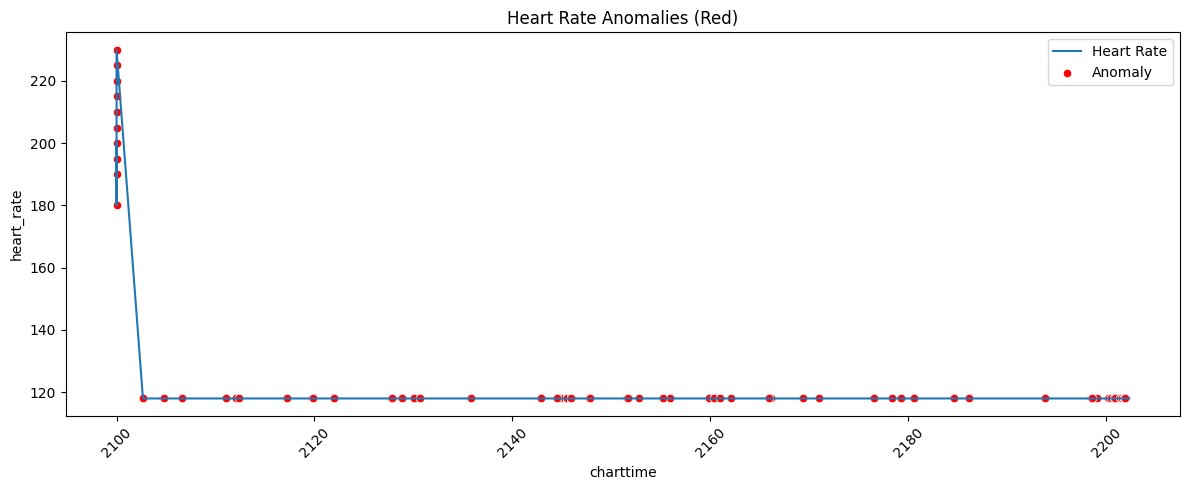

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.lineplot(data=combined, x="charttime", y="heart_rate", label="Heart Rate")
sns.scatterplot(
    data=combined[combined["anomaly"] == -1],
    x="charttime", y="heart_rate", color="red", label="Anomaly"
)
plt.xticks(rotation=45)
plt.title("Heart Rate Anomalies (Red)")
plt.tight_layout()
plt.show()
